In [28]:
import os
os.environ["DDE_BACKEND"] = "pytorch"
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

The system of ODEs,

$$\frac{dCa}{dt} \,=\, c1\,.\,v1\,.\,p_{\infty}^{3}\,.\,n_{\infty}^{3}\,.\,h^3\,.\,(Ca_{ER}-Ca) \,+\, c1\,.\,v2\,.\,(Ca_{ER}-Ca) \,-\, v3\,.\,\frac{Ca^2}{Ca^2 + k3^2} $$
$$\frac{dh}{dt}\, = \, \alpha_h(1-h)\,-\, \beta_h\,.\,h$$
where,
$$t \in [0, 300]$$
The initial conditions are,

$$Ca(0) = 0.1, \;\;\; h(0) = 0.1$$

In [29]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [30]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 1, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))
        
        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

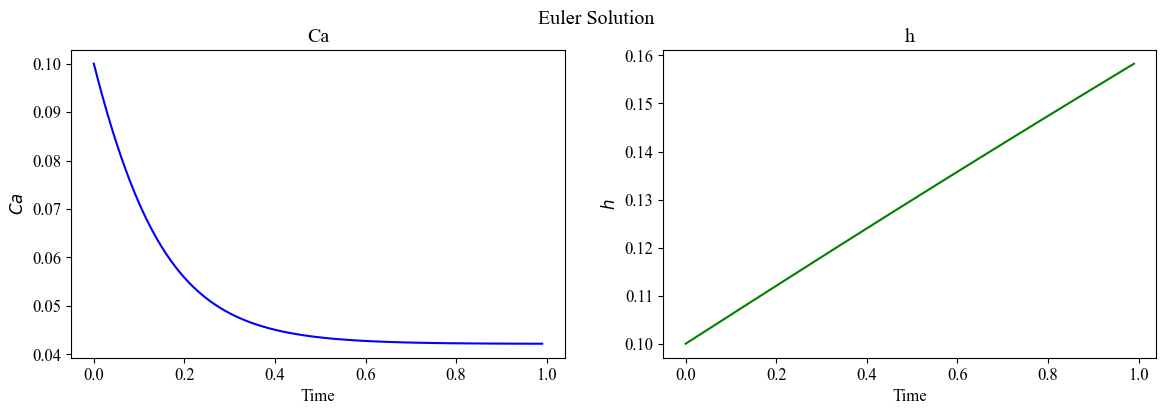

In [31]:
v2 = 0.1
a2 = 0.15
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt = 0.01
t = np.arange(0, 1, dt)
Ca_euler, h_euler = lirinzel_ns(v2, a2, IP3, d5, k3, dt)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_euler, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_euler, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [32]:
def ode_system(x, y):
    dx_dt = dde.grad.jacobian(y, x, i=0)
    dy_dt = dde.grad.jacobian(y, x, i=1)

    Ca_temp = y[:, 0:1]
    h_temp = y[:, 1:2]
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    v2 = 0.1
    a2 = 0.15
    IP3 = 0.5
    d5 = 0.09
    k3  = 0.08
    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca_temp) / c1
    ninf = Ca_temp / (Ca_temp + d5)
    tauh = 1 / (a2 * (Q2 + Ca_temp))
    hinf = Q2 / (Q2 + Ca_temp)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    eq1 = dx_dt - (c1*v1*(pinf**3)*(ninf**3)*(h_temp**3)*(CaER - Ca_temp) + c1*v2*(CaER-Ca_temp) - v3*(Ca_temp**2 / (Ca_temp**2 + k3**2)))
    eq2 = dy_dt - (alphah*(1-h_temp) - betah*h_temp)

    return [eq1, eq2]

In [33]:
def is_on_initial(x, on_initial):
    return on_initial and dde.utils.isclose(x[0], 0)

def initial_value_x(x):
    return 0.1

def initial_value_y(x):
    return 0.1

In [34]:
domain = dde.geometry.TimeDomain(0, 1)
icx = dde.icbc.IC(domain, initial_value_x, is_on_initial, component=0)
icy = dde.icbc.IC(domain, initial_value_y, is_on_initial, component=1)

In [35]:
data = dde.data.PDE(domain, ode_system, [icx, icy], num_domain=300, num_boundary=2)

In [36]:
layer_size = [1] + [30]*3 + [2]
net = dde.nn.FNN(layer_size, "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.005833 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.28e+00, 7.50e-02, 1.00e-02, 1.00e-02]    [1.28e+00, 7.50e-02, 1.00e-02, 1.00e-02]    []  
1000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
2000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
3000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
4000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
5000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
6000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
7000      [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    [1.01e+00, 4.88e-02, 8.66e-03, 6.81e-03]    []  
8

In [38]:
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.000612 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
10000     [1.00e+00, 4.86e-02, 8.66e-03, 6.81e-03]    [1.00e+00, 4.86e-02, 8.66e-03, 6.81e-03]    []  
10146     [3.27e-04, 7.80e-06, 4.06e-02, 3.09e-03]    [3.27e-04, 7.80e-06, 4.06e-02, 3.09e-03]    []  

Best model at step 10146:
  train loss: 4.40e-02
  test loss: 4.40e-02
  test metric: []

'train' took 2.010945 s



(<deepxde.model.LossHistory at 0x1395e3f1950>,
 <deepxde.model.TrainState at 0x1395c6a5a50>)

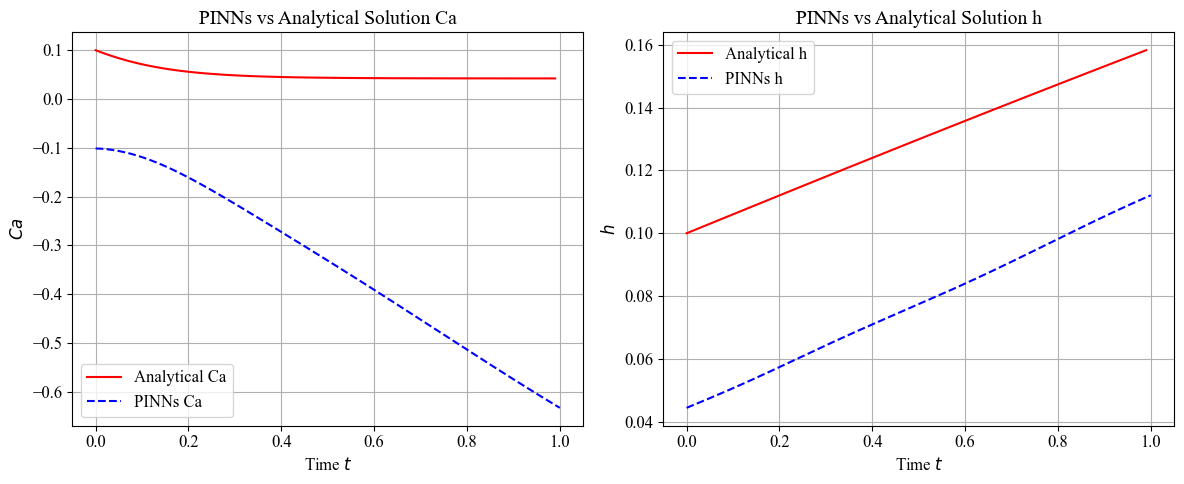

In [39]:
# Predict the solution
t_values_pinn = np.linspace(0, 1, 1000)[:, None]
y_pred = model.predict(t_values_pinn)

# Set up the plot with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t, Ca_euler, label='Analytical Ca', color='red')
plt.plot(t_values_pinn, y_pred[:, 0], '--', label="PINNs Ca", color='blue')
plt.title(r"PINNs vs Analytical Solution Ca", fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$Ca$')
plt.grid(True)
plt.legend(fontsize=12)

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t, h_euler, label='Analytical h', color='red')
plt.plot(t_values_pinn, y_pred[:, 1], '--', label="PINNs h", color='blue')
plt.title(r"PINNs vs Analytical Solution h", fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$h$')
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()